In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras

print(tf. __version__) 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

2.6.2
Num GPUs Available:  1


## Processing Data

In [2]:
def get_features_and_target(csv_file):
    df = pd.read_csv(f'../spark_output/colorado/{csv_file}')
    df.drop(['year_month_day'], axis=1, inplace=True)

    features = df.iloc[:, 1:-1].values
    target = df.iloc[:, 0].values.reshape(-1,1)

    assert features.shape[0] == target.shape[0]
    assert target.shape[1] == 1

    return features.astype('float64'), target.astype('float64')


In [3]:
def split_train_test_val(X, T):
    
    
    # Calculate standardization parameters 
    x_means = np.mean(X, axis=0)
    x_stds = np.std(X , axis=0)
    x_stds[x_stds == 0] = 1
    
    t_means = np.mean(T, axis=0)
    t_stds = np.std(T, axis=0)
    t_stds[t_stds == 0] = 1
    
    X = (X - x_means) / x_stds
    T = (T - t_means) / t_stds
    
    x_train, x_test, t_train, t_test = train_test_split(X, T, test_size=0.20, random_state=42)

    # 0.25 x 0.8 = 0.2
    x_train, x_validate, t_train, t_validate = train_test_split(x_train, t_train, test_size=0.25, random_state=42)

    assert x_train.shape[0] == t_train.shape[0]
    assert x_test.shape[0] == t_test.shape[0]
    assert x_validate.shape[0] == t_validate.shape[0]

    return [x_train, x_test, x_validate], [t_train, t_test, t_validate]

## Model Building

In [4]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(2, )))
    
    # Tune the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=10, max_value=100, step=2)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dense(1))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 5e-2, 5e-3, 5e-4])
    
              
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mae',
                metrics=['mae'])
    return model

In [5]:
def run_model_search(county):
 
    features, target = get_features_and_target(county)
    X, T = split_train_test_val(features, target)
  
    x_train, x_test, x_validate = X
    t_train, t_test, t_validate = T
    
    
    tuner = kt.Hyperband(
        model_builder,
        objective='loss',
        max_epochs=1000,
        factor=3,
        directory='SnowPredictions',
        project_name=county)
    
    
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    tuner.search(x_train, t_train, epochs=500, validation_data=(x_validate, t_validate), callbacks=[stop_early])
    
    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=100)[0]
    
    
    # Build the model with the optimal hyperparameters
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(x_train, t_train, epochs=500, validation_data=(x_validate, t_validate))
    
    mae_per_epoch = history.history['mae']
    best_epoch = mae_per_epoch.index(max(mae_per_epoch)) + 1
    print('Best epoch: %d' % (best_epoch,))
    
    hypermodel = tuner.hypermodel.build(best_hps)
    
    # Retrain the model
    history = hypermodel.fit(x_train, t_train, epochs=500, validation_data=(x_validate, t_validate))
    history.history['county'] = county
    
#     clear_output(wait=True)
    eval_result = hypermodel.evaluate(x_test, t_test)
    print("[test loss, test mae]:", eval_result)
    
    return hypermodel, history

## Display Results

In [13]:
def display_loss(model_history):

    for curr_history in model_history:
        county = curr_history.history['county']
        county = county[:county.index('.')]
        train_loss = curr_history.history['loss']
        val_loss = curr_history.history['val_loss']

        epochs = range(1, len(train_loss) + 1)

        plt.plot(train_loss, '-b', label='Training loss')
        plt.plot(val_loss, '-g', label='Validation loss')
        plt.title(f"{county}'s Training and Validation Loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

## Running Experiment

In [14]:
gunnison = "Gunnison.csv"
fremont = "Fremont.csv"

### Gunnison

In [15]:
gunnison_model, gunnison_history = run_model_search(gunnison)

INFO:tensorflow:Reloading Oracle from existing project SnowPredictions/Gunnison.csv/oracle.json
INFO:tensorflow:Reloading Tuner from SnowPredictions/Gunnison.csv/tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/500
6/6 [==============================] - ETA: 0s - loss: 0.5510 - mae: 0.5510

2021-11-29 21:30:17.676519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 35ms/step - loss: 0.5510 - mae: 0.5510 - val_loss: 0.2288 - val_mae: 0.2288
Epoch 2/500
6/6 [==============================] - 0s 10ms/step - loss: 0.2480 - mae: 0.2480 - val_loss: 0.1748 - val_mae: 0.1748
Epoch 3/500
6/6 [==============================] - 0s 10ms/step - loss: 0.2166 - mae: 0.2166 - val_loss: 0.2257 - val_mae: 0.2257
Epoch 4/500
1/6 [====>.........................] - ETA: 0s - loss: 0.2471 - mae: 0.2471

2021-11-29 21:30:17.897226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 9ms/step - loss: 0.2020 - mae: 0.2020 - val_loss: 0.1725 - val_mae: 0.1725
Epoch 5/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1875 - mae: 0.1875 - val_loss: 0.1388 - val_mae: 0.1388
Epoch 6/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1610 - mae: 0.1610 - val_loss: 0.1206 - val_mae: 0.1206
Epoch 7/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1580 - mae: 0.1580 - val_loss: 0.1534 - val_mae: 0.1534
Epoch 8/500
6/6 [==============================] - 0s 7ms/step - loss: 0.1549 - mae: 0.1549 - val_loss: 0.1235 - val_mae: 0.1235
Epoch 9/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1436 - mae: 0.1436 - val_loss: 0.1085 - val_mae: 0.1085
Epoch 10/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1467 - mae: 0.1467 - val_loss: 0.1591 - val_mae: 0.1591
Epoch 11/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1423 - mae: 0.1423 - val_loss: 0.1

6/6 [==============================] - 0s 8ms/step - loss: 0.0865 - mae: 0.0865 - val_loss: 0.1043 - val_mae: 0.1043
Epoch 68/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1096 - mae: 0.1096 - val_loss: 0.1051 - val_mae: 0.1051
Epoch 69/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1092 - mae: 0.1092 - val_loss: 0.1296 - val_mae: 0.1296
Epoch 70/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1080 - mae: 0.1080 - val_loss: 0.1035 - val_mae: 0.1035
Epoch 71/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1037 - mae: 0.1037 - val_loss: 0.1072 - val_mae: 0.1072
Epoch 72/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0995 - mae: 0.0995 - val_loss: 0.1330 - val_mae: 0.1330
Epoch 73/500
6/6 [==============================] - 0s 7ms/step - loss: 0.1234 - mae: 0.1234 - val_loss: 0.1193 - val_mae: 0.1193
Epoch 74/500
6/6 [==============================] - 0s 7ms/step - loss: 0.1201 - mae: 0.1201 - val_loss

Epoch 130/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0826 - mae: 0.0826 - val_loss: 0.0835 - val_mae: 0.0835
Epoch 131/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0875 - mae: 0.0875 - val_loss: 0.0920 - val_mae: 0.0920
Epoch 132/500
6/6 [==============================] - 0s 9ms/step - loss: 0.0880 - mae: 0.0880 - val_loss: 0.0848 - val_mae: 0.0848
Epoch 133/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0893 - mae: 0.0893 - val_loss: 0.0934 - val_mae: 0.0934
Epoch 134/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0811 - mae: 0.0811 - val_loss: 0.0996 - val_mae: 0.0996
Epoch 135/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0848 - mae: 0.0848 - val_loss: 0.0971 - val_mae: 0.0971
Epoch 136/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0899 - mae: 0.0899 - val_loss: 0.0950 - val_mae: 0.0950
Epoch 137/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0896 - m

6/6 [==============================] - 0s 7ms/step - loss: 0.0810 - mae: 0.0810 - val_loss: 0.0795 - val_mae: 0.0795
Epoch 193/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0856 - mae: 0.0856 - val_loss: 0.0953 - val_mae: 0.0953
Epoch 194/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0828 - mae: 0.0828 - val_loss: 0.0761 - val_mae: 0.0761
Epoch 195/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0823 - mae: 0.0823 - val_loss: 0.0898 - val_mae: 0.0898
Epoch 196/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0837 - mae: 0.0837 - val_loss: 0.0923 - val_mae: 0.0923
Epoch 197/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0830 - mae: 0.0830 - val_loss: 0.0685 - val_mae: 0.0685
Epoch 198/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0740 - mae: 0.0740 - val_loss: 0.1065 - val_mae: 0.1065
Epoch 199/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0861 - mae: 0.0861 - v

6/6 [==============================] - 0s 8ms/step - loss: 0.0863 - mae: 0.0863 - val_loss: 0.1051 - val_mae: 0.1051
Epoch 255/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0819 - mae: 0.0819 - val_loss: 0.0834 - val_mae: 0.0834
Epoch 256/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0776 - mae: 0.0776 - val_loss: 0.0841 - val_mae: 0.0841
Epoch 257/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0825 - mae: 0.0825 - val_loss: 0.0925 - val_mae: 0.0925
Epoch 258/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0846 - mae: 0.0846 - val_loss: 0.0940 - val_mae: 0.0940
Epoch 259/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0889 - mae: 0.0889 - val_loss: 0.0811 - val_mae: 0.0811
Epoch 260/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0908 - mae: 0.0908 - val_loss: 0.0799 - val_mae: 0.0799
Epoch 261/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0837 - mae: 0.0837 - v

6/6 [==============================] - 0s 7ms/step - loss: 0.0779 - mae: 0.0779 - val_loss: 0.0845 - val_mae: 0.0845
Epoch 317/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0805 - mae: 0.0805 - val_loss: 0.0925 - val_mae: 0.0925
Epoch 318/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0789 - mae: 0.0789 - val_loss: 0.0765 - val_mae: 0.0765
Epoch 319/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0942 - mae: 0.0942 - val_loss: 0.0959 - val_mae: 0.0959
Epoch 320/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0919 - mae: 0.0919 - val_loss: 0.1032 - val_mae: 0.1032
Epoch 321/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0805 - mae: 0.0805 - val_loss: 0.0628 - val_mae: 0.0628
Epoch 322/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0917 - mae: 0.0917 - val_loss: 0.0827 - val_mae: 0.0827
Epoch 323/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0863 - mae: 0.0863 - v

6/6 [==============================] - 0s 7ms/step - loss: 0.0729 - mae: 0.0729 - val_loss: 0.0946 - val_mae: 0.0946
Epoch 379/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0863 - mae: 0.0863 - val_loss: 0.0876 - val_mae: 0.0876
Epoch 380/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0787 - mae: 0.0787 - val_loss: 0.0895 - val_mae: 0.0895
Epoch 381/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0753 - mae: 0.0753 - val_loss: 0.0800 - val_mae: 0.0800
Epoch 382/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0727 - mae: 0.0727 - val_loss: 0.0773 - val_mae: 0.0773
Epoch 383/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0785 - mae: 0.0785 - val_loss: 0.1040 - val_mae: 0.1040
Epoch 384/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0792 - mae: 0.0792 - val_loss: 0.0821 - val_mae: 0.0821
Epoch 385/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0721 - mae: 0.0721 - v

6/6 [==============================] - 0s 7ms/step - loss: 0.0701 - mae: 0.0701 - val_loss: 0.0870 - val_mae: 0.0870
Epoch 441/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0704 - mae: 0.0704 - val_loss: 0.0831 - val_mae: 0.0831
Epoch 442/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0697 - mae: 0.0697 - val_loss: 0.0717 - val_mae: 0.0717
Epoch 443/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0729 - mae: 0.0729 - val_loss: 0.0966 - val_mae: 0.0966
Epoch 444/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0787 - mae: 0.0787 - val_loss: 0.0910 - val_mae: 0.0910
Epoch 445/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0759 - mae: 0.0759 - val_loss: 0.0718 - val_mae: 0.0718
Epoch 446/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0729 - mae: 0.0729 - val_loss: 0.0764 - val_mae: 0.0764
Epoch 447/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0699 - mae: 0.0699 - v

2021-11-29 21:30:38.971924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-29 21:30:39.162754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 29ms/step - loss: 0.5342 - mae: 0.5342 - val_loss: 0.2601 - val_mae: 0.2601
Epoch 2/500
6/6 [==============================] - 0s 8ms/step - loss: 0.2730 - mae: 0.2730 - val_loss: 0.1828 - val_mae: 0.1828
Epoch 3/500
6/6 [==============================] - 0s 8ms/step - loss: 0.2149 - mae: 0.2149 - val_loss: 0.1780 - val_mae: 0.1780
Epoch 4/500
6/6 [==============================] - 0s 8ms/step - loss: 0.2378 - mae: 0.2378 - val_loss: 0.1783 - val_mae: 0.1783
Epoch 5/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1690 - mae: 0.1690 - val_loss: 0.1769 - val_mae: 0.1769
Epoch 6/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1647 - mae: 0.1647 - val_loss: 0.1106 - val_mae: 0.1106
Epoch 7/500
6/6 [==============================] - 0s 9ms/step - loss: 0.1488 - mae: 0.1488 - val_loss: 0.1465 - val_mae: 0.1465
Epoch 8/500
6/6 [==============================] - 0s 9ms/step - loss: 0.1452 - mae: 0.1452 - val_loss: 0.12

6/6 [==============================] - 0s 7ms/step - loss: 0.0993 - mae: 0.0993 - val_loss: 0.1177 - val_mae: 0.1177
Epoch 65/500
6/6 [==============================] - 0s 7ms/step - loss: 0.1006 - mae: 0.1006 - val_loss: 0.1076 - val_mae: 0.1076
Epoch 66/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0964 - mae: 0.0964 - val_loss: 0.1105 - val_mae: 0.1105
Epoch 67/500
6/6 [==============================] - 0s 7ms/step - loss: 0.1071 - mae: 0.1071 - val_loss: 0.0899 - val_mae: 0.0899
Epoch 68/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0930 - mae: 0.0930 - val_loss: 0.1105 - val_mae: 0.1105
Epoch 69/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0966 - mae: 0.0966 - val_loss: 0.1038 - val_mae: 0.1038
Epoch 70/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0936 - mae: 0.0936 - val_loss: 0.1057 - val_mae: 0.1057
Epoch 71/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0994 - mae: 0.0994 - val_loss

Epoch 127/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0891 - mae: 0.0891 - val_loss: 0.1016 - val_mae: 0.1016
Epoch 128/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0833 - mae: 0.0833 - val_loss: 0.0947 - val_mae: 0.0947
Epoch 129/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0894 - mae: 0.0894 - val_loss: 0.0875 - val_mae: 0.0875
Epoch 130/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0946 - mae: 0.0946 - val_loss: 0.1161 - val_mae: 0.1161
Epoch 131/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0953 - mae: 0.0953 - val_loss: 0.1152 - val_mae: 0.1152
Epoch 132/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0986 - mae: 0.0986 - val_loss: 0.0892 - val_mae: 0.0892
Epoch 133/500
6/6 [==============================] - 0s 7ms/step - loss: 0.1007 - mae: 0.1007 - val_loss: 0.1291 - val_mae: 0.1291
Epoch 134/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0991 - m

6/6 [==============================] - 0s 7ms/step - loss: 0.0907 - mae: 0.0907 - val_loss: 0.0933 - val_mae: 0.0933
Epoch 190/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0915 - mae: 0.0915 - val_loss: 0.1288 - val_mae: 0.1288
Epoch 191/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0981 - mae: 0.0981 - val_loss: 0.0915 - val_mae: 0.0915
Epoch 192/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0882 - mae: 0.0882 - val_loss: 0.0959 - val_mae: 0.0959
Epoch 193/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0929 - mae: 0.0929 - val_loss: 0.0959 - val_mae: 0.0959
Epoch 194/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0839 - mae: 0.0839 - val_loss: 0.0867 - val_mae: 0.0867
Epoch 195/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0799 - mae: 0.0799 - val_loss: 0.1108 - val_mae: 0.1108
Epoch 196/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0841 - mae: 0.0841 - v

6/6 [==============================] - 0s 7ms/step - loss: 0.0722 - mae: 0.0722 - val_loss: 0.0848 - val_mae: 0.0848
Epoch 252/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0728 - mae: 0.0728 - val_loss: 0.0866 - val_mae: 0.0866
Epoch 253/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0785 - mae: 0.0785 - val_loss: 0.1057 - val_mae: 0.1057
Epoch 254/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0791 - mae: 0.0791 - val_loss: 0.0777 - val_mae: 0.0777
Epoch 255/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0788 - mae: 0.0788 - val_loss: 0.0911 - val_mae: 0.0911
Epoch 256/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0734 - mae: 0.0734 - val_loss: 0.0856 - val_mae: 0.0856
Epoch 257/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0828 - mae: 0.0828 - val_loss: 0.0849 - val_mae: 0.0849
Epoch 258/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0756 - mae: 0.0756 - v

6/6 [==============================] - 0s 7ms/step - loss: 0.0722 - mae: 0.0722 - val_loss: 0.1048 - val_mae: 0.1048
Epoch 314/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0739 - mae: 0.0739 - val_loss: 0.1026 - val_mae: 0.1026
Epoch 315/500
6/6 [==============================] - 0s 9ms/step - loss: 0.0750 - mae: 0.0750 - val_loss: 0.0888 - val_mae: 0.0888
Epoch 316/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0786 - mae: 0.0786 - val_loss: 0.0846 - val_mae: 0.0846
Epoch 317/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0798 - mae: 0.0798 - val_loss: 0.1040 - val_mae: 0.1040
Epoch 318/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0769 - mae: 0.0769 - val_loss: 0.0903 - val_mae: 0.0903
Epoch 319/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0885 - mae: 0.0885 - val_loss: 0.1000 - val_mae: 0.1000
Epoch 320/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0814 - mae: 0.0814 - v

6/6 [==============================] - 0s 7ms/step - loss: 0.0798 - mae: 0.0798 - val_loss: 0.0845 - val_mae: 0.0845
Epoch 376/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0763 - mae: 0.0763 - val_loss: 0.0858 - val_mae: 0.0858
Epoch 377/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0718 - mae: 0.0718 - val_loss: 0.0778 - val_mae: 0.0778
Epoch 378/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0769 - mae: 0.0769 - val_loss: 0.0903 - val_mae: 0.0903
Epoch 379/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0781 - mae: 0.0781 - val_loss: 0.0866 - val_mae: 0.0866
Epoch 380/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0782 - mae: 0.0782 - val_loss: 0.0906 - val_mae: 0.0906
Epoch 381/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0802 - mae: 0.0802 - val_loss: 0.0815 - val_mae: 0.0815
Epoch 382/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0741 - mae: 0.0741 - v

6/6 [==============================] - 0s 7ms/step - loss: 0.0748 - mae: 0.0748 - val_loss: 0.0893 - val_mae: 0.0893
Epoch 438/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0781 - mae: 0.0781 - val_loss: 0.1004 - val_mae: 0.1004
Epoch 439/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0787 - mae: 0.0787 - val_loss: 0.0995 - val_mae: 0.0995
Epoch 440/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0818 - mae: 0.0818 - val_loss: 0.0830 - val_mae: 0.0830
Epoch 441/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0810 - mae: 0.0810 - val_loss: 0.1021 - val_mae: 0.1021
Epoch 442/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0797 - mae: 0.0797 - val_loss: 0.0926 - val_mae: 0.0926
Epoch 443/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0761 - mae: 0.0761 - val_loss: 0.0874 - val_mae: 0.0874
Epoch 444/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0710 - mae: 0.0710 - v

6/6 [==============================] - 0s 7ms/step - loss: 0.0769 - mae: 0.0769 - val_loss: 0.1029 - val_mae: 0.1029
Epoch 500/500
2/2 [==============================] - 0s 3ms/step - loss: 0.0999 - mae: 0.0999
[test loss, test mae]: [0.09994181990623474, 0.09994181245565414]


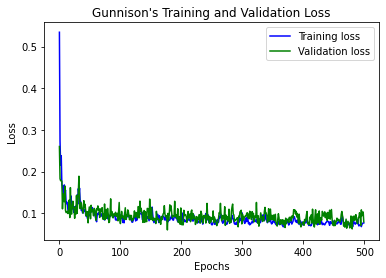

In [18]:
display_loss([gunnison_history])

### Fremont

In [19]:
fremont_model, fremont_history = run_model_search(fremont)

Trial 243 Complete [00h 00m 00s]
loss: 0.7740802764892578

Best loss So Far: 0.26514047384262085
Total elapsed time: 00h 02m 39s
INFO:tensorflow:Oracle triggered exit
Epoch 1/500
1/6 [====>.........................] - ETA: 1s - loss: 0.8845 - mae: 0.8845

2021-11-29 21:35:05.340338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 42ms/step - loss: 0.5379 - mae: 0.5379 - val_loss: 0.3797 - val_mae: 0.3797
Epoch 2/500
6/6 [==============================] - 0s 12ms/step - loss: 0.2693 - mae: 0.2693 - val_loss: 0.3390 - val_mae: 0.3390
Epoch 3/500
1/6 [====>.........................] - ETA: 0s - loss: 0.2470 - mae: 0.2470

2021-11-29 21:35:05.616840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 11ms/step - loss: 0.2575 - mae: 0.2575 - val_loss: 0.2897 - val_mae: 0.2897
Epoch 4/500
6/6 [==============================] - 0s 9ms/step - loss: 0.2183 - mae: 0.2183 - val_loss: 0.2574 - val_mae: 0.2574
Epoch 5/500
6/6 [==============================] - 0s 11ms/step - loss: 0.2148 - mae: 0.2148 - val_loss: 0.2650 - val_mae: 0.2650
Epoch 6/500
6/6 [==============================] - 0s 11ms/step - loss: 0.2161 - mae: 0.2161 - val_loss: 0.2610 - val_mae: 0.2610
Epoch 7/500
6/6 [==============================] - 0s 9ms/step - loss: 0.2042 - mae: 0.2042 - val_loss: 0.2403 - val_mae: 0.2403
Epoch 8/500
6/6 [==============================] - 0s 11ms/step - loss: 0.2035 - mae: 0.2035 - val_loss: 0.2529 - val_mae: 0.2529
Epoch 9/500
6/6 [==============================] - 0s 11ms/step - loss: 0.2029 - mae: 0.2029 - val_loss: 0.2335 - val_mae: 0.2335
Epoch 10/500
6/6 [==============================] - 0s 9ms/step - loss: 0.1945 - mae: 0.1945 - val_loss:

6/6 [==============================] - 0s 10ms/step - loss: 0.1859 - mae: 0.1859 - val_loss: 0.2037 - val_mae: 0.2037
Epoch 67/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1753 - mae: 0.1753 - val_loss: 0.1980 - val_mae: 0.1980
Epoch 68/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1723 - mae: 0.1723 - val_loss: 0.2101 - val_mae: 0.2101
Epoch 69/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1708 - mae: 0.1708 - val_loss: 0.1969 - val_mae: 0.1969
Epoch 70/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1853 - mae: 0.1853 - val_loss: 0.2110 - val_mae: 0.2110
Epoch 71/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1979 - mae: 0.1979 - val_loss: 0.2104 - val_mae: 0.2104
Epoch 72/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1986 - mae: 0.1986 - val_loss: 0.2083 - val_mae: 0.2083
Epoch 73/500
6/6 [==============================] - 0s 9ms/step - loss: 0.2191 - mae: 0.2191 - val_los

Epoch 129/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1459 - mae: 0.1459 - val_loss: 0.2028 - val_mae: 0.2028
Epoch 130/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1433 - mae: 0.1433 - val_loss: 0.1949 - val_mae: 0.1949
Epoch 131/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1496 - mae: 0.1496 - val_loss: 0.1949 - val_mae: 0.1949
Epoch 132/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1672 - mae: 0.1672 - val_loss: 0.2239 - val_mae: 0.2239
Epoch 133/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1803 - mae: 0.1803 - val_loss: 0.2238 - val_mae: 0.2238
Epoch 134/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1675 - mae: 0.1675 - val_loss: 0.1859 - val_mae: 0.1859
Epoch 135/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1596 - mae: 0.1596 - val_loss: 0.1976 - val_mae: 0.1976
Epoch 136/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1491 - m

6/6 [==============================] - 0s 8ms/step - loss: 0.1425 - mae: 0.1425 - val_loss: 0.2215 - val_mae: 0.2215
Epoch 192/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1594 - mae: 0.1594 - val_loss: 0.1870 - val_mae: 0.1870
Epoch 193/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1433 - mae: 0.1433 - val_loss: 0.1896 - val_mae: 0.1896
Epoch 194/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1384 - mae: 0.1384 - val_loss: 0.2067 - val_mae: 0.2067
Epoch 195/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1381 - mae: 0.1381 - val_loss: 0.1804 - val_mae: 0.1804
Epoch 196/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1336 - mae: 0.1336 - val_loss: 0.1992 - val_mae: 0.1992
Epoch 197/500
6/6 [==============================] - 0s 10ms/step - loss: 0.1383 - mae: 0.1383 - val_loss: 0.1969 - val_mae: 0.1969
Epoch 198/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1351 - mae: 0.1351 - 

6/6 [==============================] - 0s 8ms/step - loss: 0.1375 - mae: 0.1375 - val_loss: 0.2053 - val_mae: 0.2053
Epoch 254/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1343 - mae: 0.1343 - val_loss: 0.1972 - val_mae: 0.1972
Epoch 255/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1286 - mae: 0.1286 - val_loss: 0.1729 - val_mae: 0.1729
Epoch 256/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1333 - mae: 0.1333 - val_loss: 0.1814 - val_mae: 0.1814
Epoch 257/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1271 - mae: 0.1271 - val_loss: 0.1921 - val_mae: 0.1921
Epoch 258/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1242 - mae: 0.1242 - val_loss: 0.1819 - val_mae: 0.1819
Epoch 259/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1248 - mae: 0.1248 - val_loss: 0.1798 - val_mae: 0.1798
Epoch 260/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1248 - mae: 0.1248 - v

6/6 [==============================] - 0s 8ms/step - loss: 0.1350 - mae: 0.1350 - val_loss: 0.1743 - val_mae: 0.1743
Epoch 316/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1337 - mae: 0.1337 - val_loss: 0.1867 - val_mae: 0.1867
Epoch 317/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1409 - mae: 0.1409 - val_loss: 0.2006 - val_mae: 0.2006
Epoch 318/500
6/6 [==============================] - 0s 9ms/step - loss: 0.1343 - mae: 0.1343 - val_loss: 0.1959 - val_mae: 0.1959
Epoch 319/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1351 - mae: 0.1351 - val_loss: 0.1750 - val_mae: 0.1750
Epoch 320/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1423 - mae: 0.1423 - val_loss: 0.1740 - val_mae: 0.1740
Epoch 321/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1369 - mae: 0.1369 - val_loss: 0.1851 - val_mae: 0.1851
Epoch 322/500
6/6 [==============================] - 0s 9ms/step - loss: 0.1364 - mae: 0.1364 - v

6/6 [==============================] - 0s 8ms/step - loss: 0.1151 - mae: 0.1151 - val_loss: 0.1878 - val_mae: 0.1878
Epoch 378/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1128 - mae: 0.1128 - val_loss: 0.1798 - val_mae: 0.1798
Epoch 379/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1164 - mae: 0.1164 - val_loss: 0.1963 - val_mae: 0.1963
Epoch 380/500
6/6 [==============================] - 0s 9ms/step - loss: 0.1277 - mae: 0.1277 - val_loss: 0.2135 - val_mae: 0.2135
Epoch 381/500
6/6 [==============================] - 0s 9ms/step - loss: 0.1274 - mae: 0.1274 - val_loss: 0.1974 - val_mae: 0.1974
Epoch 382/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1205 - mae: 0.1205 - val_loss: 0.1818 - val_mae: 0.1818
Epoch 383/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1224 - mae: 0.1224 - val_loss: 0.1985 - val_mae: 0.1985
Epoch 384/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1176 - mae: 0.1176 - v

6/6 [==============================] - 0s 9ms/step - loss: 0.1180 - mae: 0.1180 - val_loss: 0.1865 - val_mae: 0.1865
Epoch 440/500
6/6 [==============================] - 0s 9ms/step - loss: 0.1109 - mae: 0.1109 - val_loss: 0.1957 - val_mae: 0.1957
Epoch 441/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1102 - mae: 0.1102 - val_loss: 0.1886 - val_mae: 0.1886
Epoch 442/500
6/6 [==============================] - 0s 9ms/step - loss: 0.1139 - mae: 0.1139 - val_loss: 0.1899 - val_mae: 0.1899
Epoch 443/500
6/6 [==============================] - 0s 9ms/step - loss: 0.1131 - mae: 0.1131 - val_loss: 0.1902 - val_mae: 0.1902
Epoch 444/500
6/6 [==============================] - 0s 9ms/step - loss: 0.1086 - mae: 0.1086 - val_loss: 0.1795 - val_mae: 0.1795
Epoch 445/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1110 - mae: 0.1110 - val_loss: 0.1937 - val_mae: 0.1937
Epoch 446/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1111 - mae: 0.1111 - v

2021-11-29 21:35:30.869932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 45ms/step - loss: 0.5633 - mae: 0.5633 - val_loss: 0.5220 - val_mae: 0.5220
Epoch 2/500
6/6 [==============================] - 0s 12ms/step - loss: 0.3361 - mae: 0.3361 - val_loss: 0.3053 - val_mae: 0.3053
Epoch 3/500
1/6 [====>.........................] - ETA: 0s - loss: 0.2235 - mae: 0.2235

2021-11-29 21:35:31.153495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 10ms/step - loss: 0.2457 - mae: 0.2457 - val_loss: 0.2800 - val_mae: 0.2800
Epoch 4/500
6/6 [==============================] - 0s 10ms/step - loss: 0.2253 - mae: 0.2253 - val_loss: 0.2780 - val_mae: 0.2780
Epoch 5/500
6/6 [==============================] - 0s 9ms/step - loss: 0.2189 - mae: 0.2189 - val_loss: 0.2529 - val_mae: 0.2529
Epoch 6/500
6/6 [==============================] - 0s 10ms/step - loss: 0.2099 - mae: 0.2099 - val_loss: 0.2841 - val_mae: 0.2841
Epoch 7/500
6/6 [==============================] - 0s 9ms/step - loss: 0.2424 - mae: 0.2424 - val_loss: 0.2555 - val_mae: 0.2555
Epoch 8/500
6/6 [==============================] - 0s 8ms/step - loss: 0.2784 - mae: 0.2784 - val_loss: 0.2325 - val_mae: 0.2325
Epoch 9/500
6/6 [==============================] - 0s 9ms/step - loss: 0.2134 - mae: 0.2134 - val_loss: 0.2740 - val_mae: 0.2740
Epoch 10/500
6/6 [==============================] - 0s 12ms/step - loss: 0.2115 - mae: 0.2115 - val_loss: 

6/6 [==============================] - 0s 8ms/step - loss: 0.1799 - mae: 0.1799 - val_loss: 0.1914 - val_mae: 0.1914
Epoch 67/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1738 - mae: 0.1738 - val_loss: 0.2073 - val_mae: 0.2073
Epoch 68/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1863 - mae: 0.1863 - val_loss: 0.2053 - val_mae: 0.2053
Epoch 69/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1741 - mae: 0.1741 - val_loss: 0.1910 - val_mae: 0.1910
Epoch 70/500
6/6 [==============================] - 0s 9ms/step - loss: 0.1656 - mae: 0.1656 - val_loss: 0.2137 - val_mae: 0.2137
Epoch 71/500
6/6 [==============================] - 0s 9ms/step - loss: 0.1908 - mae: 0.1908 - val_loss: 0.2077 - val_mae: 0.2077
Epoch 72/500
6/6 [==============================] - 0s 9ms/step - loss: 0.1703 - mae: 0.1703 - val_loss: 0.2017 - val_mae: 0.2017
Epoch 73/500
6/6 [==============================] - 0s 12ms/step - loss: 0.1692 - mae: 0.1692 - val_los

Epoch 129/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1568 - mae: 0.1568 - val_loss: 0.2226 - val_mae: 0.2226
Epoch 130/500
6/6 [==============================] - 0s 9ms/step - loss: 0.1483 - mae: 0.1483 - val_loss: 0.1979 - val_mae: 0.1979
Epoch 131/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1541 - mae: 0.1541 - val_loss: 0.1774 - val_mae: 0.1774
Epoch 132/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1407 - mae: 0.1407 - val_loss: 0.1918 - val_mae: 0.1918
Epoch 133/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1498 - mae: 0.1498 - val_loss: 0.2117 - val_mae: 0.2117
Epoch 134/500
6/6 [==============================] - 0s 12ms/step - loss: 0.1456 - mae: 0.1456 - val_loss: 0.1962 - val_mae: 0.1962
Epoch 135/500
6/6 [==============================] - 0s 9ms/step - loss: 0.1708 - mae: 0.1708 - val_loss: 0.1880 - val_mae: 0.1880
Epoch 136/500
6/6 [==============================] - 0s 9ms/step - loss: 0.1560 - 

6/6 [==============================] - 0s 9ms/step - loss: 0.1393 - mae: 0.1393 - val_loss: 0.1944 - val_mae: 0.1944
Epoch 192/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1569 - mae: 0.1569 - val_loss: 0.1779 - val_mae: 0.1779
Epoch 193/500
6/6 [==============================] - 0s 10ms/step - loss: 0.1324 - mae: 0.1324 - val_loss: 0.1851 - val_mae: 0.1851
Epoch 194/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1395 - mae: 0.1395 - val_loss: 0.1835 - val_mae: 0.1835
Epoch 195/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1587 - mae: 0.1587 - val_loss: 0.2174 - val_mae: 0.2174
Epoch 196/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1617 - mae: 0.1617 - val_loss: 0.1841 - val_mae: 0.1841
Epoch 197/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1343 - mae: 0.1343 - val_loss: 0.2008 - val_mae: 0.2008
Epoch 198/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1382 - mae: 0.1382 - 

6/6 [==============================] - 0s 9ms/step - loss: 0.1272 - mae: 0.1272 - val_loss: 0.2101 - val_mae: 0.2101
Epoch 254/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1316 - mae: 0.1316 - val_loss: 0.1998 - val_mae: 0.1998
Epoch 255/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1322 - mae: 0.1322 - val_loss: 0.2128 - val_mae: 0.2128
Epoch 256/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1396 - mae: 0.1396 - val_loss: 0.1875 - val_mae: 0.1875
Epoch 257/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1343 - mae: 0.1343 - val_loss: 0.2041 - val_mae: 0.2041
Epoch 258/500
6/6 [==============================] - 0s 10ms/step - loss: 0.1316 - mae: 0.1316 - val_loss: 0.2034 - val_mae: 0.2034
Epoch 259/500
6/6 [==============================] - 0s 10ms/step - loss: 0.1301 - mae: 0.1301 - val_loss: 0.1881 - val_mae: 0.1881
Epoch 260/500
6/6 [==============================] - 0s 9ms/step - loss: 0.1343 - mae: 0.1343 -

6/6 [==============================] - 0s 8ms/step - loss: 0.1247 - mae: 0.1247 - val_loss: 0.2233 - val_mae: 0.2233
Epoch 316/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1217 - mae: 0.1217 - val_loss: 0.1949 - val_mae: 0.1949
Epoch 317/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1244 - mae: 0.1244 - val_loss: 0.2120 - val_mae: 0.2120
Epoch 318/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1417 - mae: 0.1417 - val_loss: 0.1836 - val_mae: 0.1836
Epoch 319/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1299 - mae: 0.1299 - val_loss: 0.1843 - val_mae: 0.1843
Epoch 320/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1276 - mae: 0.1276 - val_loss: 0.2044 - val_mae: 0.2044
Epoch 321/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1211 - mae: 0.1211 - val_loss: 0.1897 - val_mae: 0.1897
Epoch 322/500
6/6 [==============================] - 0s 9ms/step - loss: 0.1132 - mae: 0.1132 - v

6/6 [==============================] - 0s 8ms/step - loss: 0.1209 - mae: 0.1209 - val_loss: 0.2011 - val_mae: 0.2011
Epoch 378/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1176 - mae: 0.1176 - val_loss: 0.1866 - val_mae: 0.1866
Epoch 379/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1039 - mae: 0.1039 - val_loss: 0.2158 - val_mae: 0.2158
Epoch 380/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1112 - mae: 0.1112 - val_loss: 0.2249 - val_mae: 0.2249
Epoch 381/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1089 - mae: 0.1089 - val_loss: 0.1835 - val_mae: 0.1835
Epoch 382/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1148 - mae: 0.1148 - val_loss: 0.1891 - val_mae: 0.1891
Epoch 383/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1182 - mae: 0.1182 - val_loss: 0.2218 - val_mae: 0.2218
Epoch 384/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1246 - mae: 0.1246 - v

6/6 [==============================] - 0s 8ms/step - loss: 0.1041 - mae: 0.1041 - val_loss: 0.1962 - val_mae: 0.1962
Epoch 440/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1036 - mae: 0.1036 - val_loss: 0.1932 - val_mae: 0.1932
Epoch 441/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1118 - mae: 0.1118 - val_loss: 0.2112 - val_mae: 0.2112
Epoch 442/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1125 - mae: 0.1125 - val_loss: 0.2136 - val_mae: 0.2136
Epoch 443/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1160 - mae: 0.1160 - val_loss: 0.2208 - val_mae: 0.2208
Epoch 444/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1084 - mae: 0.1084 - val_loss: 0.2349 - val_mae: 0.2349
Epoch 445/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1135 - mae: 0.1135 - val_loss: 0.2140 - val_mae: 0.2140
Epoch 446/500
6/6 [==============================] - 0s 8ms/step - loss: 0.1162 - mae: 0.1162 - v

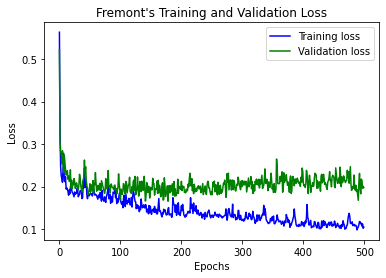

In [20]:
display_loss([fremont_history])